In [1]:
import os
import gc

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import lightgbm as lgb

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head(3)
test.head(3)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1


In [4]:
df_merchants = pd.read_csv('merchants.csv')
df_hist = pd.read_csv('historical_transactions.csv')
df_newmerchants = pd.read_csv('new_merchant_transactions.csv')

In [5]:
df_merchants.head(3)
df_hist.head(3)
df_newmerchants.head(3)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14


In [6]:
def missing_impute(df):
    for i in df.columns:
        if df[i].dtype == "object":
            df[i] = df[i].fillna("other")
        elif (df[i].dtype == "int64" or df[i].dtype == "float64"):
            df[i] = df[i].fillna(df[i].mean())
        else:
            pass
    return df

In [7]:
for df in [train, test, df_merchants, df_hist, df_newmerchants]:
    missing_impute(df)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749
5,2016-09,C_ID_0894217f2f,4,2,0,0.871585
6,2016-12,C_ID_7e63323c00,3,2,1,0.230129
7,2017-09,C_ID_dfa21fc124,3,2,1,2.135850
8,2017-08,C_ID_fe0fdac8ea,2,1,0,-0.065406
9,2016-08,C_ID_bf62c0b49d,2,2,0,0.300062


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1
5,2017-07,C_ID_5814b4f13c,5,1,1
6,2017-10,C_ID_a1b3c75277,1,2,0
7,2017-02,C_ID_f7cada36d3,3,1,1
8,2017-07,C_ID_9d2bc8dfc4,4,3,0
9,2016-03,C_ID_6d8dba8475,5,1,1


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.400000,9.666667e+00,3,-2.250000e+00,1.866667e+01,6,-2.320000e+00,1.391667e+01,12,N,242,9,1.000000
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.720000,1.750000e+00,3,-7.400000e-01,1.291667e+00,6,-5.700000e-01,1.687500e+00,12,N,22,16,1.000000
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.130000,2.600000e+02,2,-8.213000e+01,2.600000e+02,2,-8.213000e+01,2.600000e+02,2,N,-1,5,5.000000
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,13.832993,1.666667e+00,3,2.165079e+01,4.666667e+00,6,2.522771e+01,3.833333e+00,12,Y,-1,-1,2.380002
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,13.832993,5.000000e-01,3,2.165079e+01,3.611111e-01,6,2.522771e+01,3.472222e-01,12,Y,-1,-1,2.380002
5,M_ID_a0915f62b5,20201,87,27,-0.057471,-0.057471,N,E,E,13.832993,1.000000e+00,3,2.165079e+01,3.666667e+00,6,2.522771e+01,3.833333e+00,12,Y,160,21,5.000000
6,M_ID_bfd41933db,33861,792,9,-0.057471,-0.057471,N,E,E,13.832993,2.833333e+00,3,2.165079e+01,4.833333e+00,6,2.522771e+01,6.333333e+00,12,N,60,16,1.000000
7,M_ID_d8ff08219e,16430,529,20,-0.057471,-0.057471,Y,E,E,13.832993,1.000000e+00,3,2.165079e+01,1.666667e+00,6,2.522771e+01,1.500000e+00,11,Y,-1,-1,2.380002
8,M_ID_c5b389236d,37179,813,29,-0.057471,-0.057471,N,E,E,13.832993,1.150000e+02,3,2.165079e+01,1.899167e+02,6,2.522771e+01,1.970000e+02,7,N,248,15,1.000000
9,M_ID_d2162ed113,112122,81,29,-0.057471,-0.057471,Y,E,E,13.832993,1.000000e+00,2,2.165079e+01,1.000000e+00,2,2.522771e+01,1.000000e+00,2,Y,-1,-1,2.380002


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.000000,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.000000,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.000000,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.000000,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.000000,16,37
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,-0.734887,2018-02-24 08:45:05,1.000000,9,37
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,-0.716855,2017-03-21 00:10:51,1.000000,16,37
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,-0.657049,2017-11-18 20:05:55,1.000000,16,37
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,-0.737967,2017-06-01 22:02:56,1.000000,16,37
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,-0.715352,2017-03-16 15:41:22,1.000000,16,37


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.000000,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.000000,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.000000,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,2.197841,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,2.197841,-1,29
5,Y,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,1.000000,9,16
6,Y,C_ID_ef55cf8d4b,69,N,1,B,333,M_ID_6d061b5ddc,1,5.263697,2018-03-28 19:50:19,1.000000,9,10
7,Y,C_ID_ef55cf8d4b,231,N,1,B,307,M_ID_df1e022f41,2,-0.553787,2018-04-05 08:06:52,1.000000,9,19
8,Y,C_ID_ef55cf8d4b,69,N,1,B,278,M_ID_d15eae0468,2,-0.596643,2018-04-07 18:37:40,1.000000,9,37
9,Y,C_ID_ef55cf8d4b,69,N,1,B,437,M_ID_5f9bffd028,1,-0.607191,2018-03-17 18:10:41,1.000000,9,15


In [8]:
# Define the aggregation procedure outside of the groupby operation
aggregations = {
    'purchase_amount': ['sum', 'mean', 'std', 'min', 'max', 'size', 'median']
}

grouped = df_hist.groupby('card_id').agg(aggregations)
grouped.columns = grouped.columns.droplevel(level=0)
grouped.rename(columns={
    "sum": "sum_purchase_amount", 
    "mean": "mean_purchase_amount",
    "std": "std_purchase_amount", 
    "min": "min_purchase_amount",
    "max": "max_purchase_amount", 
    "size": "num_purchase_amount",
    "median": "median_purchase_amount"
}, inplace=True)
grouped.reset_index(inplace=True)
grouped.head(3)

,card_id,sum_purchase_amount,mean_purchase_amount,std_purchase_amount,min_purchase_amount,max_purchase_amount,num_purchase_amount,median_purchase_amount
0,C_ID_00007093c1,-76.845041,-0.515739,0.298141,-0.728876,1.507069,149,-0.587627
1,C_ID_0001238066,-72.447201,-0.589002,0.190235,-0.734887,0.768095,123,-0.648184
2,C_ID_0001506ef0,-34.601879,-0.524271,0.472284,-0.740491,1.493545,66,-0.703707


In [9]:
train = pd.merge(train, grouped, on="card_id", how="left")
test = pd.merge(test, grouped, on="card_id", how="left")

del grouped
gc.collect()
train.shape
test.shape

42

(201917, 13)

(123623, 12)

In [10]:
# Define the aggregation procedure outside of the groupby operation
aggregations = {
    'purchase_amount': ['sum', 'mean', 'std', 'min', 'max', 'size', 'median']
}

grouped = df_newmerchants.groupby('card_id').agg(aggregations)
grouped.columns = grouped.columns.droplevel(level=0)
grouped.rename(columns={
    "sum": "sum_purchase_amount", 
    "mean": "mean_purchase_amount",
    "std": "std_purchase_amount", 
    "min": "min_purchase_amount",
    "max": "max_purchase_amount", 
    "size": "num_purchase_amount",
    "median": "median_purchase_amount"
}, inplace=True)
grouped.reset_index(inplace=True)

train = pd.merge(train, grouped, on="card_id", how="left")
test = pd.merge(test, grouped, on="card_id", how="left")

del grouped
gc.collect()

train.shape
test.shape

42

(201917, 20)

(123623, 19)

In [11]:
# One-hot encode features
ohe_df_1 = pd.get_dummies(train['feature_1'], prefix='f1_')
ohe_df_2 = pd.get_dummies(train['feature_2'], prefix='f2_')
ohe_df_3 = pd.get_dummies(train['feature_3'], prefix='f3_')

ohe_df_4 = pd.get_dummies(test['feature_1'], prefix='f1_')
ohe_df_5 = pd.get_dummies(test['feature_2'], prefix='f2_')
ohe_df_6 = pd.get_dummies(test['feature_3'], prefix='f3_')

# Numerical representation of the first active month
train = pd.concat([train, ohe_df_1, ohe_df_2, ohe_df_3], axis=1, sort=False)
test = pd.concat([test, ohe_df_4, ohe_df_5, ohe_df_6], axis=1, sort=False)

del ohe_df_1, ohe_df_2, ohe_df_3
del ohe_df_4, ohe_df_5, ohe_df_6
gc.collect()

train.shape, test.shape

train.head(3)

21

((201917, 30), (123623, 29))

,first_active_month,card_id,feature_1,feature_2,feature_3,target,sum_purchase_amount_x,mean_purchase_amount_x,std_purchase_amount_x,min_purchase_amount_x,max_purchase_amount_x,num_purchase_amount_x,median_purchase_amount_x,sum_purchase_amount_y,mean_purchase_amount_y,std_purchase_amount_y,min_purchase_amount_y,max_purchase_amount_y,num_purchase_amount_y,median_purchase_amount_y,f1__1,f1__2,f1__3,f1__4,f1__5,f2__1,f2__2,f2__3,f3__0,f3__1
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,-165.968739,-0.638341,0.212139,-0.739395,2.258395,260,-0.698042,-13.244202,-0.575835,0.135812,-0.724368,-0.296112,23.0,-0.581180,0,0,0,0,1,0,1,0,0,1
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,-210.006336,-0.600018,0.384967,-0.742400,4.630299,350,-0.708590,-4.355735,-0.725956,0.014326,-0.739410,-0.701858,6.0,-0.732633,0,0,0,1,0,1,0,0,1,0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,-29.167391,-0.678311,0.087380,-0.730138,-0.145847,43,-0.698868,-0.700326,-0.700326,NaN,-0.700326,-0.700326,1.0,-0.700326,0,1,0,0,0,0,1,0,1,0


In [12]:
excluded_features = ['first_active_month', 'card_id', 'target']
train_features = [c for c in train.columns if c not in excluded_features]

In [13]:
train.isnull().sum()

first_active_month              0
card_id                         0
feature_1                       0
feature_2                       0
feature_3                       0
target                          0
sum_purchase_amount_x           0
mean_purchase_amount_x          0
std_purchase_amount_x           0
min_purchase_amount_x           0
max_purchase_amount_x           0
num_purchase_amount_x           0
median_purchase_amount_x        0
sum_purchase_amount_y       21931
mean_purchase_amount_y      21931
std_purchase_amount_y       48718
min_purchase_amount_y       21931
max_purchase_amount_y       21931
num_purchase_amount_y       21931
median_purchase_amount_y    21931
f1__1                           0
f1__2                           0
f1__3                           0
f1__4                           0
f1__5                           0
f2__1                           0
f2__2                           0
f2__3                           0
f3__0                           0
f3__1         

In [14]:
for col in train_features:
    for df in [train, test]:
        if df[col].dtype == "float64":
            df[col] = df[col].fillna(df[col].mean())

In [20]:
X = train.copy()
y = X['target']

# Split data with kfold
kfolds = KFold(n_splits=5, shuffle=True, random_state=2018)

# Make importance dataframe
importances = pd.DataFrame()

oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(test.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(kfolds.split(X, y)):
    X_train, y_train = X[train_features].iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X[train_features].iloc[val_idx], y.iloc[val_idx]
    
    # LightGBM Regressor estimator
    model = lgb.LGBMRegressor(
        num_leaves = 31,
        learning_rate = 0.01,
        n_estimators = 1000,
        random_state = 100,
        nthread = 4
    )
    
    # Fit
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=None, eval_metric='rmse',
        early_stopping_rounds=100
    )
    
    # Feature importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = model.booster_.feature_importance(importance_type='gain')
    imp_df['fold'] = n_fold + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_preds[val_idx] = model.predict(X_valid, num_iteration=model.best_iteration_)
    test_preds = model.predict(test[train_features], num_iteration=model.best_iteration_)
    sub_preds += test_preds / kfolds.n_splits
    
mean_squared_error(y, oof_preds) ** .5

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.01, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, nthread=4, num_leaves=31,
       objective=None, random_state=100, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.01, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, nthread=4, num_leaves=31,
       objective=None, random_state=100, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.01, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, nthread=4, num_leaves=31,
       objective=None, random_state=100, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.01, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, nthread=4, num_leaves=31,
       objective=None, random_state=100, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.01, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, nthread=4, num_leaves=31,
       objective=None, random_state=100, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

3.8158390649087974

In [16]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.shape
len(sub_preds)

(123623, 2)

123623

In [17]:
sample_submission['target'] = sub_preds
#sample_submission.to_csv("baseline_submission.csv", index=False)
sample_submission.head()

,card_id,target
0,C_ID_0ab67a22ab,-0.713131
1,C_ID_130fd0cbdd,-0.503081
2,C_ID_b709037bc5,-0.871816
3,C_ID_d27d835a9f,-0.337438
4,C_ID_2b5e3df5c2,-1.623435


In [18]:
sample_submission.target.min()
sample_submission.target.max()
sample_submission.target.mean()

-4.309715132658565

2.2756779015747033

-0.4774678359604882

In [19]:
train.target.min()
train.target.max()
train.target.mean()

-33.21928095

17.9650684

-0.39363629907797143

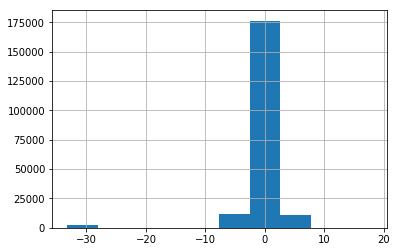

In [5]:
train.target.hist()